## Forest Cover Type Dataset

Playing around with a Kaggle dataset.  Using queries, SQL, Transformers and ML methods


Tree types found in Roosevelt National Forest in Colorado

Kaggle dataset downloaded from:
- kaggle.com/uciml/forest-cover-type-dataset

Try using various transformers and machine learning models on a Kaggle dataset


Attribute Information:

Given is the attribute name, attribute type, the measurement unit and a brief description. The forest cover type is the classification problem. The order of this listing corresponds to the order of numerals along the rows of the database.

Name / Data Type / Measurement / Description

- Elevation / quantitative /meters / Elevation in meters
- Aspect / quantitative / azimuth / Aspect in degrees azimuth
- Slope / quantitative / degrees / Slope in degrees
- Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway
- Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice
- Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice
- Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation
- Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation
- Cover_Type (7 types) / integer / 1 to 7 / Forest Cover Type designation

In [1]:
import findspark
findspark.init('/home/rich/spark/spark-2.4.3-bin-hadoop2.7')
import pandas as pd
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import matplotlib.pyplot as plt

import pyspark.sql.functions as F
import pyspark.ml.feature as feat
import numpy as np


In [2]:
spark = SparkSession.builder.master('local[*]').appName('Forest').getOrCreate()

In [3]:
# Read data from CSV file
forest = spark.read.csv('./data/covtype.csv',sep=',',header=True,inferSchema=True)

In [4]:
print("The data contain %d records." % forest.count())

The data contain 581012 records.


In [5]:
forest.printSchema()

root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Wilderness_Area_Rawah: integer (nullable = true)
 |-- Wilderness_Area_Neota: integer (nullable = true)
 |-- Wilderness_Area_Comanche: integer (nullable = true)
 |-- Wilderness_Area_CacheLaPoudre: integer (nullable = true)
 |-- Soil_type_2702: integer (nullable = true)
 |-- Soil_type_2703: integer (nullable = true)
 |-- Soil_type_2704: integer (nullable = true)
 |-- Soil_type_2705: integer (nullable = true)
 |-- Soil_type_2706: integer (nullable = true)
 |-- Soil_type_2

In [6]:
forest.select('Horizontal_Distance_To_Hydrology').show(10)

+--------------------------------+
|Horizontal_Distance_To_Hydrology|
+--------------------------------+
|                             258|
|                             212|
|                             268|
|                             242|
|                             153|
|                             300|
|                             270|
|                             234|
|                             240|
|                             247|
+--------------------------------+
only showing top 10 rows



### Bucketizing

Putting the *Horizontal_Distance_To_Hydrology* into discrete buckets

In [7]:
#getting min and max using sql
forest.createOrReplaceTempView("Hydro")
query = '''select min(Horizontal_Distance_To_Hydrology) as min, 
           max(Horizontal_Distance_To_Hydrology) as max from Hydro'''
forest_hydro = spark.sql(query)
forest_hydro.show()

+---+----+
|min| max|
+---+----+
|  0|1397|
+---+----+



In [8]:
#getting min and max using dot notation
row = forest.agg({"Horizontal_Distance_To_Hydrology":"max"}).collect()[0][0]
print(row)

#another way
forest.select(F.max(F.col("Horizontal_Distance_To_Hydrology")).alias("MAX")).collect()[0]

1397


Row(MAX=1397)

In [9]:
#a faster way to do it
#want 10 buckets
buckets_no = 10

dist_min_max = (
    forest.agg(
          F.min('Horizontal_Distance_To_Hydrology')
            .alias('min')
        , F.max('Horizontal_Distance_To_Hydrology')
            .alias('max')
    )
    .rdd
    .map(lambda row: (row.min, row.max))
    .collect()[0]
)
print(dist_min_max)

(0, 1397)


In [10]:
#get the range of values
rng = dist_min_max[1] - dist_min_max[0]

#make a list of thresholds, use numpy arange min, max,step size
splits = list(np.arange(dist_min_max[0],dist_min_max[1],rng/(buckets_no+1)))
splits

[0.0, 127.0, 254.0, 381.0, 508.0, 635.0, 762.0, 889.0, 1016.0, 1143.0, 1270.0]

In [11]:
#make and apply the bucketizer
bucketizer = feat.Bucketizer(
        splits = splits,
        inputCol = 'Horizontal_Distance_To_Hydrology',
        outputCol = 'Horizontal_Distance_To_Hydrology_Bkt'
)
#use object to transform the df
bucketizer.transform(forest).select(
                                    'Horizontal_Distance_To_Hydrology',
                                    'Horizontal_Distance_To_Hydrology_Bkt'
                                    ).show(10)

+--------------------------------+------------------------------------+
|Horizontal_Distance_To_Hydrology|Horizontal_Distance_To_Hydrology_Bkt|
+--------------------------------+------------------------------------+
|                             258|                                 2.0|
|                             212|                                 1.0|
|                             268|                                 2.0|
|                             242|                                 1.0|
|                             153|                                 1.0|
|                             300|                                 2.0|
|                             270|                                 2.0|
|                             234|                                 1.0|
|                             240|                                 1.0|
|                             247|                                 1.0|
+--------------------------------+------------------------------

### Vectorizing
VectorAssembler collates multiple features into a single column


In [12]:
vectorAssembler = feat.VectorAssembler(inputCols=forest.columns,outputCol='feat')
vectorAssembler.getOutputCol()

'feat'

In [13]:
#apply pca to all the features
pca = feat.PCA(k=5,inputCol=vectorAssembler.getOutputCol(),outputCol='pca_feat')

(
pca.fit(vectorAssembler.transform(forest))
        .transform(vectorAssembler.transform(forest))
        .select('feat','pca_feat').take(1)
)

[Row(feat=SparseVector(55, {0: 2596.0, 1: 51.0, 2: 3.0, 3: 258.0, 5: 510.0, 6: 221.0, 7: 232.0, 8: 148.0, 9: 6279.0, 10: 1.0, 42: 1.0, 54: 5.0}), pca_feat=DenseVector([-3887.7711, 4996.8103, 2323.0932, 1014.5873, -135.1702]))]

Produced the top 5 pca components

### Estimators
Try classification and regression techniques using two models from ML library 

In [14]:
import pyspark.ml.classification as cl

#get just the features as vectorassembler
vectorAssembler = feat.VectorAssembler(inputCols=forest.columns[:-1],outputCol='features')

#transform the dataset, check  and cast whether target equal to 1
forest_data = (
        vectorAssembler
        .transform(forest)
        .withColumn('label',(F.col('CoverType')==1).cast('integer'))
    .select('label','features')

)
#use log reg model
log_obj = cl.LogisticRegression()
log_model = log_obj.fit(forest_data)


In [15]:
log_model.coefficients

DenseVector([0.0071, -0.0004, -0.0155, -0.0014, -0.0015, -0.0001, -0.0019, -0.0251, 0.0065, 0.0, -6.0389, -7.0751, -6.6708, -16.7513, -5.0649, -11.4737, -13.9752, -5.4082, -4.5281, -6.4561, -12.6817, -4.6724, -3.0293, -4.2446, -4.9244, -5.4026, -4.9246, -8.1625, -3.7149, -4.3748, -4.6184, -6.8022, -4.0672, -3.9113, 0.5552, -3.6307, -3.9406, -4.1827, -5.597, -4.967, -3.8844, -4.9093, -4.9629, -5.118, -4.2124, -4.6844, -4.2862, -6.3924, -6.3938, -7.2371, -16.6593, -5.795, -5.8279, -6.3668])

In [17]:
forest_data.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(54,[0,1,2,3,5,6,...|
|    0|(54,[0,1,2,3,4,5,...|
|    0|(54,[0,1,2,3,4,5,...|
|    0|(54,[0,1,2,3,4,5,...|
|    0|(54,[0,1,2,3,4,5,...|
+-----+--------------------+
only showing top 5 rows



In [22]:
#using regression techinques - try to predict elevation
import pyspark.ml.regression as rg

#forest.select('Elevation').show(5)

assembler = feat.VectorAssembler(inputCols = forest.columns[1:],outputCol='features')

#cast to float as regression problem
elevation_data = (
    assembler
    .transform(forest)
    .withColumn(
        'label'
        , F.col('Elevation').cast('float'))
    .select('label', 'features')
)

In [26]:
elevation_data.show(5,truncate=False)

+------+-----------------------------------------------------------------------------------------------------+
|label |features                                                                                             |
+------+-----------------------------------------------------------------------------------------------------+
|2596.0|(54,[0,1,2,4,5,6,7,8,9,41,53],[51.0,3.0,258.0,510.0,221.0,232.0,148.0,6279.0,1.0,1.0,5.0])           |
|2590.0|(54,[0,1,2,3,4,5,6,7,8,9,41,53],[56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,1.0,5.0])    |
|2804.0|(54,[0,1,2,3,4,5,6,7,8,9,24,53],[139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,1.0,2.0])  |
|2785.0|(54,[0,1,2,3,4,5,6,7,8,9,42,53],[155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,1.0,2.0])|
|2595.0|(54,[0,1,2,3,4,5,6,7,8,9,41,53],[45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,1.0,5.0])    |
+------+-----------------------------------------------------------------------------------------------------+
o

In [28]:
lr_obj = rg.LinearRegression(
    maxIter=10
    , regParam=0.01
    , elasticNetParam=1.00)
lr_model = lr_obj.fit(elevation_data)

lr_model.coefficients

DenseVector([0.0309, 0.6522, 0.1911, 0.1424, 0.0342, 0.7402, 1.053, -0.0017, -0.0041, 2.7163, 189.0362, 27.8238, -265.8505, -407.4379, -346.0612, -364.3841, -302.6788, -400.5852, -212.9918, -126.1329, -117.7423, -312.0478, -248.7118, -221.4788, -155.1459, -84.5129, -398.0433, -387.8102, -179.4485, -261.3875, -337.7875, 48.0629, -94.7813, 149.8043, 135.144, 80.0901, 64.3659, 124.0233, -115.0126, 119.1285, -181.7498, 10.8056, -42.7849, 65.5441, 102.2562, 36.9865, -48.1163, 379.2091, 256.0169, 497.1714, 313.0607, 337.172, 397.0758, -14.4551])

In [29]:
summary = lr_model.summary

print(
    summary.r2
    , summary.rootMeanSquaredError
    , summary.meanAbsoluteError
)

0.7860412464754158 129.50871925702575 103.34079732698777


R^2 of 0.786 means we have modelled well using LR on this feature

### Pipelines
Chain together Transformers and Estimators to form a sequential workflow

In [32]:
from pyspark.ml import Pipeline

assembler = feat.VectorAssembler(
    inputCols=forest.columns[1:]
    , outputCol='features')

lr_obj = rg.LinearRegression(
    labelCol='Elevation'
    , maxIter=10
    , regParam=0.01
)

#create the pipeline and use on dataset
pip = Pipeline(stages=[assembler, lr_obj])

(
    pip
    .fit(forest)
    .transform(forest)
    .select('Elevation', 'prediction')
    .show(10)
)

+---------+------------------+
|Elevation|        prediction|
+---------+------------------+
|     2596|2840.7801831411316|
|     2590|2828.7464246669683|
|     2804| 2842.761272955131|
|     2785| 2966.057500325109|
|     2595|2817.1687155114637|
|     2579|2892.6436548111983|
|     2606| 2844.248065926093|
|     2605|2838.8097383254494|
|     2617|2845.6749236394053|
|     2612|2841.6531550057234|
+---------+------------------+
only showing top 10 rows



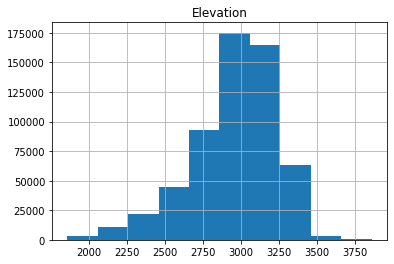

In [34]:
#what is distribution of elevation?
transformed_df = forest.select('Elevation')
transformed_df.toPandas().hist();

Almost a gaussian dist.

### Feature Selection

use chi square to select top 10 best features

In [36]:
assembler = feat.VectorAssembler(
    inputCols=forest.columns[0:-1]
    , outputCol='features'
)

selector = feat.ChiSqSelector(
    labelCol='CoverType'
    , numTopFeatures=10
    , outputCol='selected')

pipeline_sel = Pipeline(stages=[assembler, selector])

(
    pipeline_sel
    .fit(forest)
    .transform(forest)
    .select(selector.getOutputCol())
    .show(5)
)

+--------------------+
|            selected|
+--------------------+
|(10,[0,1,2,3,5,6,...|
|(10,[0,1,2,3,4,5,...|
|(10,[0,1,2,3,4,5,...|
|(10,[0,1,2,3,4,5,...|
|(10,[0,1,2,3,4,5,...|
+--------------------+
only showing top 5 rows



For regression problems select best features by checking the correlations between each and very feature and the target and slect those that are most hghly correlated with the target but exhibit little to no correlation with other features

### Predicting forest coverage types

In [62]:
#train test split
forest_train, forest_test = (forest.randomSplit([0.75,0.25],seed=27))

#vectorize the features
assembler = feat.VectorAssembler(inputCols=forest.columns[:-1],outputCol='features')

In [63]:
print(forest_train.count())
print(forest_test.count())

435321
145691


In [64]:
#select 10 features
selector = feat.ChiSqSelector(
    labelCol='CoverType'
    , numTopFeatures=10
    , outputCol='selected')

In [65]:
#apply logistic regression
logReg_obj = cl.LogisticRegression(
    labelCol='CoverType'
    , featuresCol=selector.getOutputCol()
    , regParam=0.01
    , elasticNetParam=1.0
    , family='multinomial'
)

In [66]:
#make and fit our piepline
pipeline = Pipeline(
    stages=[
        vectorAssembler
        , selector
        , logReg_obj
    ])

pModel = pipeline.fit(forest_train)

In [67]:
import pyspark.ml.evaluation as ev

#get the predictions for the unseen data
results_logReg = (
    pModel
    .transform(forest_test)
    .select('CoverType', 'probability', 'prediction')
)


#calculate the performance on the model.  
evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'  #name of the column that contains the predicted class for observatuions
    , labelCol='CoverType')  #true label

(
    #return the results default is F1 score 
    evaluator.evaluate(results_logReg)
    , evaluator.evaluate(
        results_logReg
        , {evaluator.metricName: 'weightedPrecision'}
    ) 
    , evaluator.evaluate(
        results_logReg
        , {evaluator.metricName: 'accuracy'}
    )
)

(0.6005001943648852, 0.5819004790151103, 0.6335326135451057)

Accruacy of around sixty percent

### Tuning the hyperparameters

Try a simple grid search using the regularization param.  Only select 5 features for speed  

In [75]:
import pyspark.ml.tuning as tune

#assembler and selector same as above

selector = feat.ChiSqSelector(
    labelCol='CoverType'
    , numTopFeatures=5
    , outputCol='selected')

logReg_obj = cl.LogisticRegression(
    labelCol='CoverType'
    , featuresCol=selector.getOutputCol()
    , family='multinomial'
)

In [77]:
#build the grid regulariztion techniques
logReg_grid = (
    tune.ParamGridBuilder()
    .addGrid(logReg_obj.regParam
            , [0.05, 0.1]
        )
    .build()
)

In [78]:
logReg_ev = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='CoverType')

#cv by default on 3 folds
cross_v = tune.CrossValidator(
    estimator=logReg_obj
    , estimatorParamMaps=logReg_grid
    , evaluator=logReg_ev
)

pipeline = Pipeline(stages=[vectorAssembler, selector])
data_trans = pipeline.fit(forest_train)

logReg_modelTest = cross_v.fit(
    data_trans.transform(forest_train)
)

In [79]:
#evaluate on test dataset
data_trans_test = data_trans.transform(forest_test)
results = logReg_modelTest.transform(data_trans_test)

print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedPrecision'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedRecall'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'accuracy'}))

0.5989028399279137
0.6523464043763857
0.6523464043763857
